## Computational Photography
## Duke Kunshan University Fall 2017
### David Brady
Monday 27 November 2017

## Noise



In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import glob
from time import gmtime, strftime, sleep
import re
from scipy import interpolate as interp
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

/Users/yeko/anaconda/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


Today's lecture focuses on noise and the physical capture process on a sensor. Let's begin by comparing noise in raw and compressed images

below we difine functions to grab either jpeg compressed (fm 1) or raw images and functions to demosaic and color balance the raw images.

The raw image format is different in JetPack 3, so the raw image capture script has changed. See if you can see the differences, the current functions are not perfect. 

In [2]:
def grabImage(sid=1, imres=8, fm=1, cameraNumber=6):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='ssh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='scp ubuntu@10.0.1.'+str(cameraNumber)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
                    --file-name dbGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    if fm==1:
        fileName = re.search(r'dbGrab(.*).jpg', rePop)
        fileName=fileName.group()
        pop=imio.imread(fileName)
    else:
        fileName = re.search(r'(.*).raw', rePop)
        fileName=fileName.group()
        pop=np.fromfile(fileName,dtype=np.dtype('i2'))
        pop=pop[250416:]
        pop=np.reshape(pop,(2174,3864))
       # pop=np.append(pop[:,2060:] ,pop[:,:2060],axis=1)
    return pop

In [3]:
def demosaic(rawImage):
    red=rawImage[0:2174:2,1:3864:2]
    redU=interp.RectBivariateSpline(np.arange(0,1087),np.arange(0,1932),red)
    red=redU(np.arange(0,1087,.5),np.arange(0,1932,.5))
    red=np.append(red[:,744:] ,red[:,:744],axis=1)
    blue=rawImage[1:2174:2,0:3864:2]
    blueU=interp.RectBivariateSpline(np.arange(0,1087),np.arange(0,1932),blue)
    blue=blueU(np.arange(0,1087,.5),np.arange(0,1932,.5))
    blue=np.append(blue[:,744:] ,blue[:,:744],axis=1)
    green=rawImage;
    for er in range(1,2173,2):
        for odr in range(0,3862,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    for er in range(0,2172,2):
        for odr in range(1,3861,2):
            green[er,odr]=np.mean([green[er-1,odr], green[er,odr-1],green[er+1,odr], green[er,odr+1]])
    green=np.append(green[:,744:] ,green[:,:744],axis=1)
    imageOut=np.dstack((red,green,blue))
    imageOut=255*imageOut/np.max(imageOut)
    imageOut=imageOut.astype(np.uint8)
    return imageOut

In [4]:
def adjustColor(inputImage,rc=1,bc=1,gc=1,gain=1,contrast=1):
    fI=inputImage.astype(np.float)
    fI[:,:,0]=rc*fI[:,:,0]
    fI[:,:,1]=gc*fI[:,:,1]
    fI[:,:,2]=bc*fI[:,:,2]
    fI=gain*fI/np.max(fI)
    fI=255*np.tanh(contrast*fI)
    fI=fI.astype(np.uint8)
    return fI

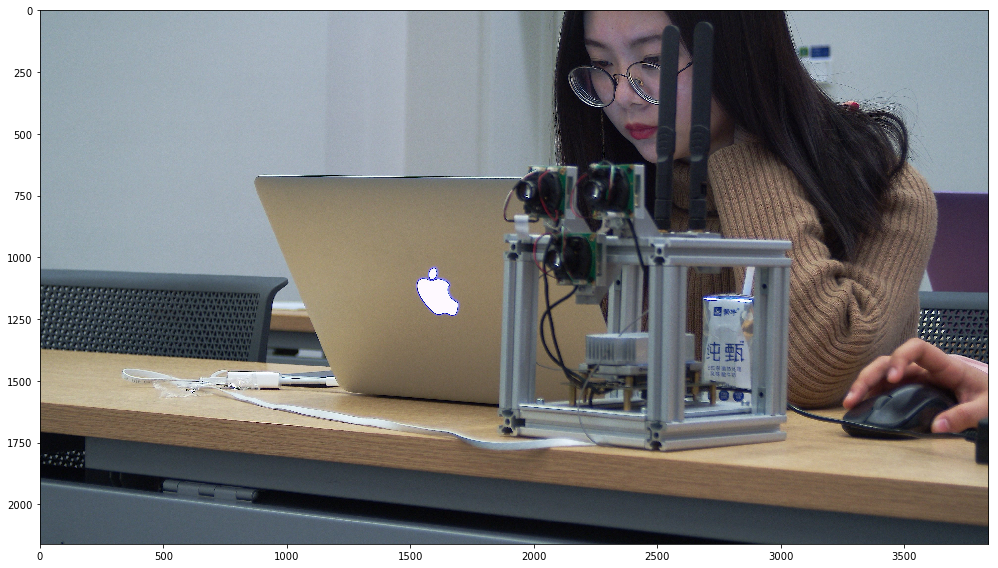

In [18]:
a = grabImage(sid=0, fm=1, cameraNumber=8)
imio.imshow(a)

lets zoom into the captured jpeg image to see if we can see details. In a compressed image, most of the image features observed when zooming in are more closely related to compression artifacts rather than pixel noise

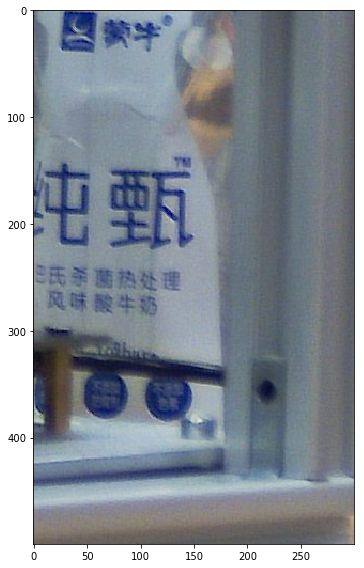

In [20]:
imio.imshow(a[1200:1700,2700:3000,:])

zooming in further, the "blocky" structure of the image is definitely a result of compression rather than noise . The image is smoothed by compression and denoising.

/Users/yeko/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


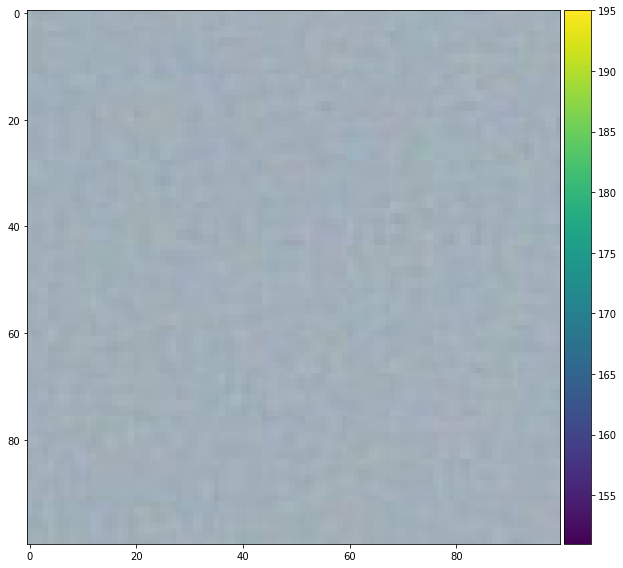

In [21]:
imio.imshow(a[500:600,500:600,:])

now lets look at the raw image. Numbers had to be adjusted to see the raw image, the structure has changed in this release

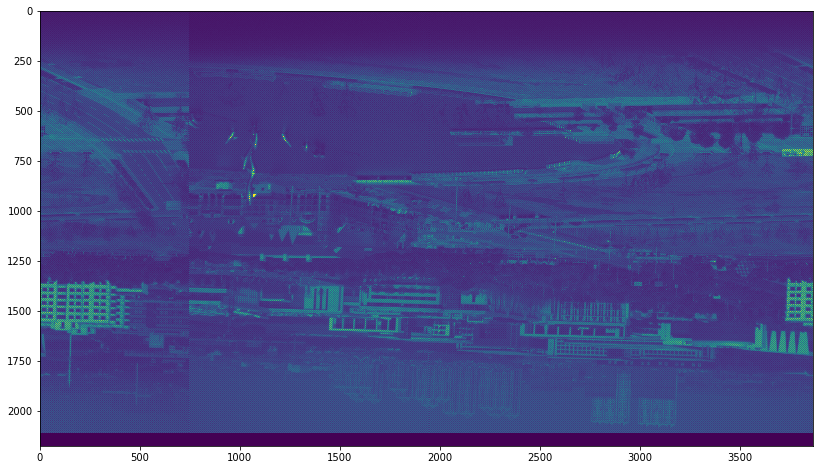

In [247]:
b = grabImage(fm=2)
plt.imshow(b)

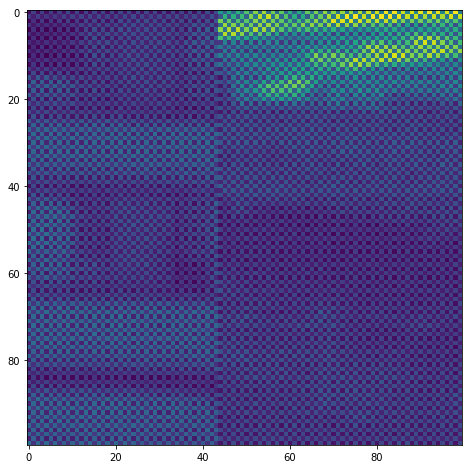

In [248]:
plt.imshow(b[1500:1600,700:800])

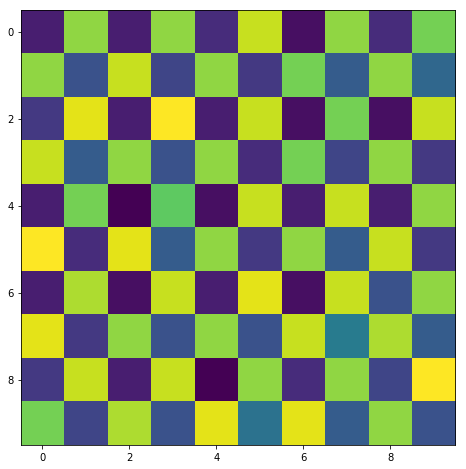

In [249]:
plt.imshow(b[10:20,10:20])

for column less than 745, greens are ee and oo

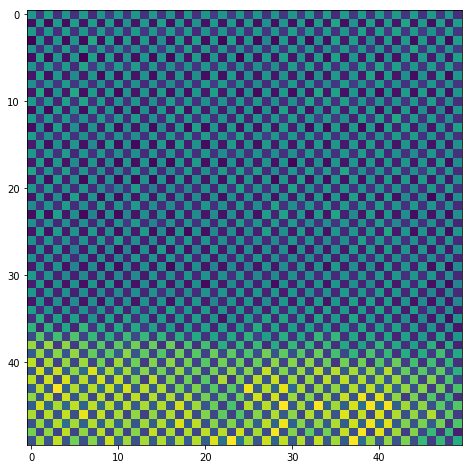

In [250]:
plt.imshow(b[750:800,750:800])

for column greatr than 745, greens are still ee and oo but blue red switched? The red/blue sampling in the image below is not right

In [265]:
c=demosaic(b)

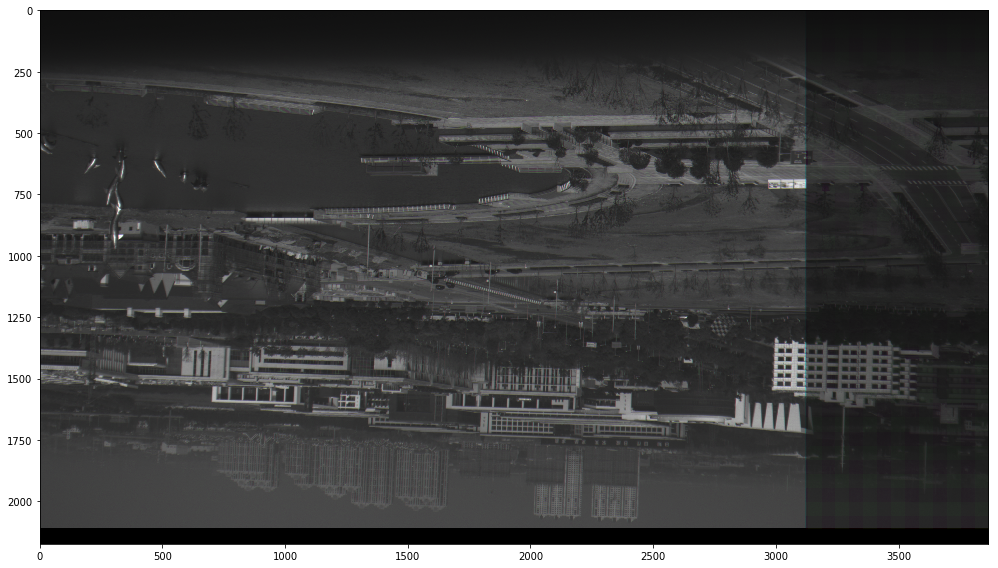

In [266]:
imio.imshow(c)

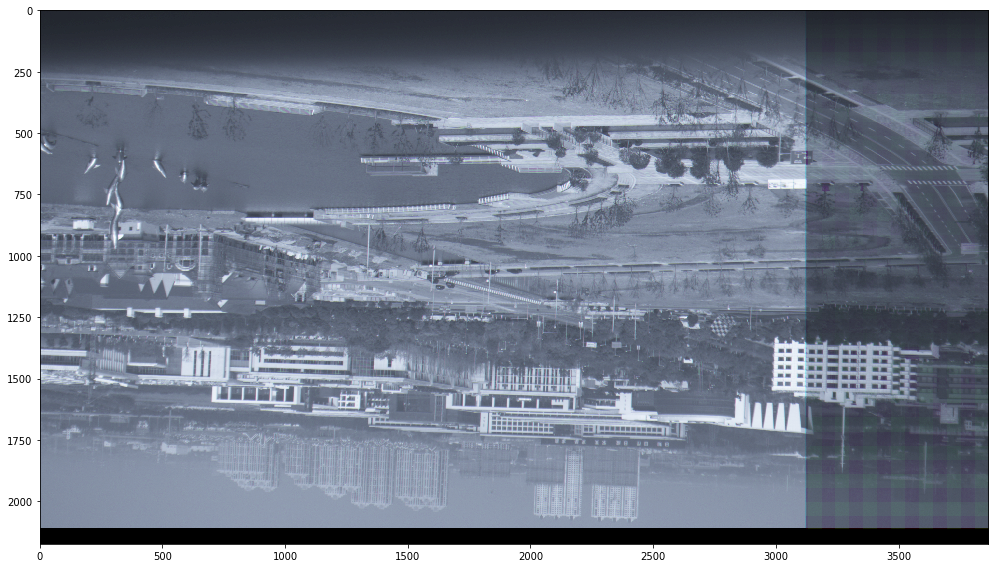

In [278]:
d=adjustColor(c,bc=1.2,gc=1,rc=.9,gain=3)
imio.imshow(d)

zooming in on details in the raw image, we see that the image is less blocky because it is not compressed, but that the image is also noisier

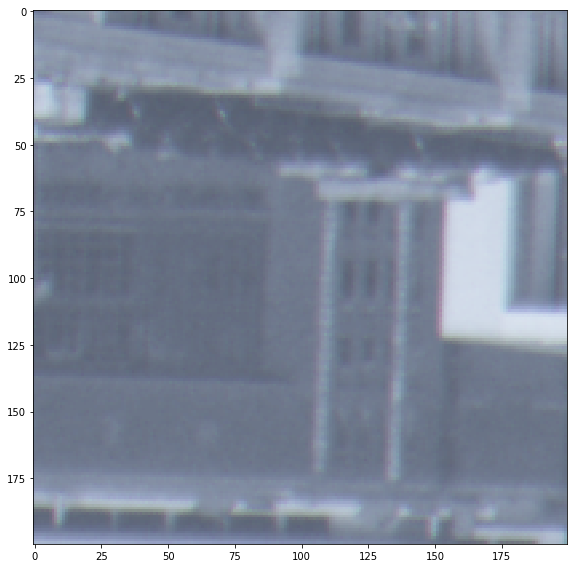

In [279]:
imio.imshow(d[1500:1700,1500:1700,:])

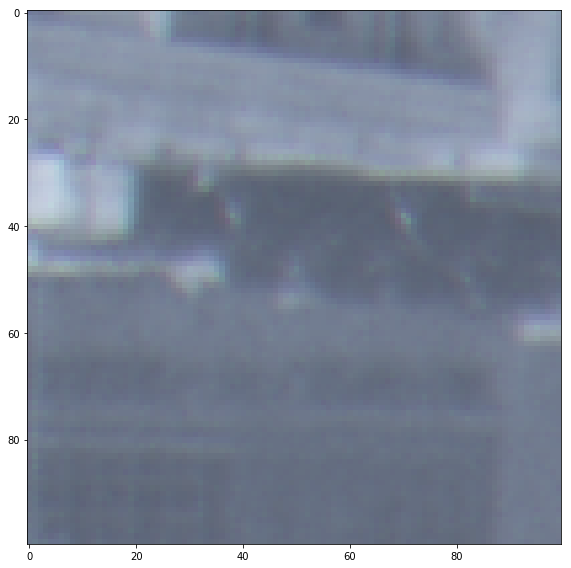

In [280]:
imio.imshow(d[1500:1600,1500:1600,:])

 lets grab a bunch of frames and look at their statistics. Here we choose to take a subset of raw pixels randomly distributed in the image

In [281]:
def RawPixelSamples(sid=1, imres=8, cameraNumber=6, frames=100, samplePixels=10000):
    # I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='rsh ubuntu@10.0.1.'+str(cameraNumber)
    cmdB='rcp ubuntu@10.0.1.'+str(cameraNumber)
    pixels=np.random.randint(250416,2160*3840,samplePixels)
    subprocess.run('rm dbGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab some images on the tegra
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto -C '+str(frames)+' --dump-bayer\
    --capture-gap 500 --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.findall(r'(.*).raw', rePop)
    pop=np.fromfile(fileName[0]+'.raw',dtype=np.dtype('i2'))
    pixelValues=pop[pixels]
    for index in range(1,len(fileName)):
        pop=np.fromfile(fileName[index]+'.raw',dtype=np.dtype('i2'))
        pixelValues=np.vstack((pixelValues,pop[pixels]))
                              
    return pixelValues

In [282]:
dog=RawPixelSamples()

In [283]:
pixelMean=np.mean(dog,axis=0)

In [284]:
min(pixelMean)

908.15999999999997

In [285]:
max(pixelMean)

14716.620000000001

In [286]:
pixelStd=np.std(dog,axis=0)

In [287]:
max(pixelStd)

2077.2697899887726

In [288]:
min(pixelStd)

12.617701850971107

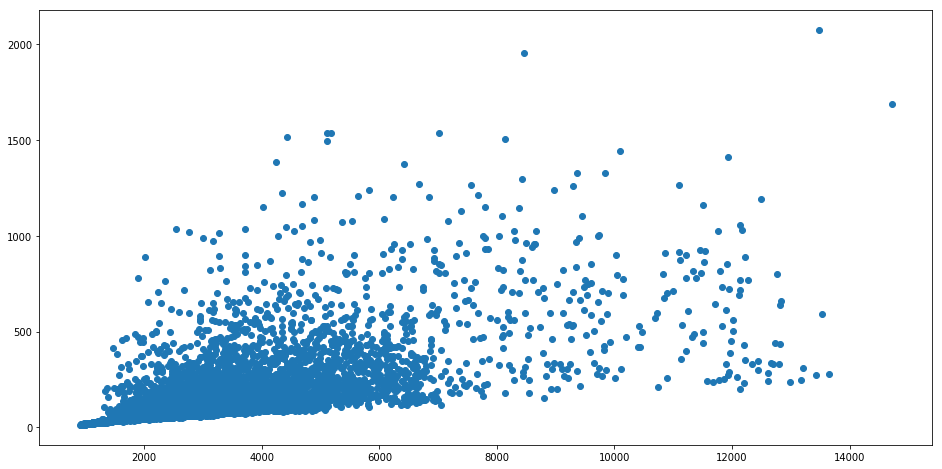

In [289]:
plt.scatter(pixelMean,pixelStd)

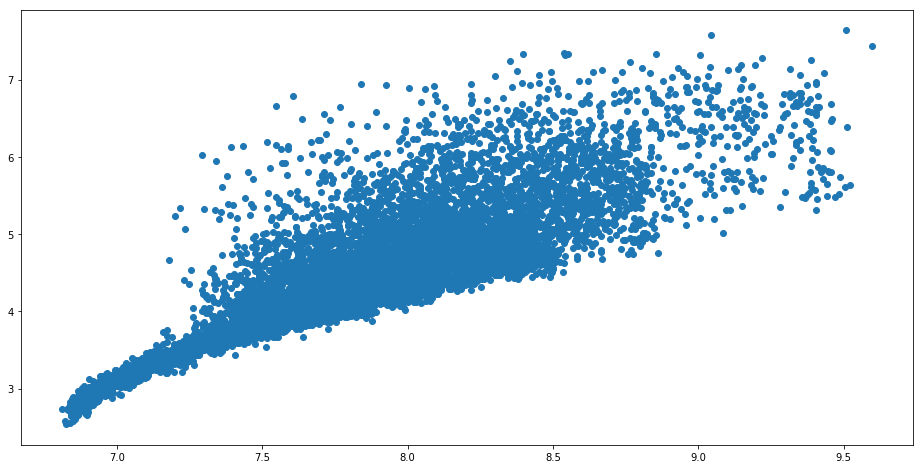

In [290]:
plt.scatter(np.log(pixelMean),np.log(pixelStd))